# Make High Dimensional Embedding Labels

## Imports and Utils

In [24]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
from gensim.utils import tokenize

from skimage.transform import resize
import numpy as np
import librosa
import librosa.display
import os

import torch
import torch.nn.functional as F

In [2]:
def make_kv(classes: list, embeddings: np.ndarray):
    kv = {classes[i] : embeddings[i] for i, _ in enumerate(classes)}
    return kv

def word_euclidean_distance(w1: str, w2: str, kv: dict):
    """
    Get euclidean distance between two word embeddings
    kv: maps strings to embedding vector, ex: {"dog":[[10.39, -3.0, ...]]}
    """
    arr1, arr2 = kv[w1], kv[w2]
    diff = arr1 - arr2
    return np.linalg.norm(diff)


def get_same_distances(category, embeddings):
    same_distances = {}
    for c1 in category:
        c_other = category.copy()
        c_other.remove(c1)
        distances = [word_euclidean_distance(c1, c2, embeddings) for c2 in c_other]
        same_distances[c1] = distances
    mean_same_distances = {key: np.mean(value) for key, value in same_distances.items()}
    return same_distances, mean_same_distances

def get_across_distances(category1, category2, embeddings):
    across_distances = {}
    for c1 in category1:
        distances = [word_euclidean_distance(c1, c2, embeddings) for c2 in category2]
        across_distances[c1] = distances
    mean_across_distances = {key: np.mean(value) for key, value in across_distances.items()}
    return across_distances, mean_across_distances


def plot_distances(mean_same_distances: list, mean_across_distances: list, classes:list, embedding_type):
    fig, ax = plt.subplots(figsize=(12,6))
    bar_width = 0.35
    index = np.arange(len(classes))
    
    bar1 = ax.bar(index, 
                  [mean_same_distances[c] for c in classes], 
                  bar_width, 
                  label='Within Category')
    
    bar2 = ax.bar(index + bar_width, 
                  [mean_across_distances[c] for c in classes], 
                  bar_width, 
                  label='Across Category')
    
    ax.set_xlabel('Class')
    ax.set_ylabel('Average Distance')
    ax.set_title(f"Average Distances: {embedding_type} Embedding")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(classes)
    ax.legend()
    
    plt.show()


### Class Labels

In [3]:
classes = ["airplane",   # 0 - v
          "automobile",  # 1 - v
          "bird",        # 2 - a
          "cat",         # 3 - a 
          "deer",        # 4 - a
          "dog",         # 5 - a
          "frog",        # 6 - a 
          "horse",       # 7 - a
          "ship",        # 8 - v
          "truck"]       # 9 - v

animal_idxs = [2, 3, 4, 5, 6, 7]
vehicle_idxs = [0, 1, 8 , 9]

animals = [classes[i] for i in animal_idxs]
vehicles = [classes[i] for i in vehicle_idxs]

print(f"Cifar10 classes: {', '.join(classes)}")
print(f"Cifar10 animals: {', '.join(animals)}")
print(f"Cifar10 vehicles: {', '.join(vehicles)}")

Cifar10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
Cifar10 animals: bird, cat, deer, dog, frog, horse
Cifar10 vehicles: airplane, automobile, ship, truck


## Speech

In [4]:
directory = "../data/audio"
file_nms = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
suffix = ".wav"

mels = np.ndarray(shape=(10, 64, 64), dtype='float32')
for i in range(10):
    y, sr = librosa.load(os.path.join(directory, file_nms[i]+suffix), sr=22050)
    y, _ = librosa.effects.trim(y)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=256, n_mels=64, fmax=8000)
    mel = librosa.power_to_db(mel, ref=np.max)
    mel = resize(mel, (64, 64))
    mels[i] = mel
speech_kv = make_kv(classes, mels)

In [6]:
speech_kv["airplane"].shape

(64, 64)

## Language

### Glove

In [46]:
glove_vectors = {}
with open("data/glove.6B.50d.txt", encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            glove_vectors[word] = [float(i) for i in vector] 

glove_embeddings = np.array([glove_vectors[c] for c in classes])
with open('glove_embeddings.npy', 'wb') as f:
    np.save(f, glove_embeddings)

glove_kv = make_kv(classes, glove_embeddings)

In [47]:
glove_kv['airplane']

array([ 1.2977   , -0.29922  ,  0.66154  , -0.20133  , -0.02502  ,
        0.28644  , -1.0811   , -0.13045  ,  0.64917  , -0.33634  ,
        0.53352  ,  0.32792  , -0.43206  ,  1.4613   ,  0.022957 ,
       -0.26019  , -1.1061   ,  1.077    , -0.99877  , -1.3468   ,
        0.39016  ,  0.43799  , -1.0403   , -0.36612  ,  0.39231  ,
       -1.3089   , -0.82404  ,  0.63095  ,  1.2513   ,  0.10211  ,
        1.2735   , -0.0050163, -0.39469  ,  0.36387  ,  0.65099  ,
       -0.21433  ,  0.52291  , -0.079013 , -0.14676  ,  0.89248  ,
       -0.31447  ,  0.090903 ,  0.78216  , -0.10842  , -0.3186   ,
        0.16068  , -0.20168  , -0.095033 , -0.010109 ,  0.19048  ])

### W2V

In [7]:
w2v_path = "data/word2vec-google-news-300.model"
wv = KeyedVectors.load(w2v_path, mmap='r')
w2v_embeddings = np.array([wv[c] for c in classes])
with open('cifar10_w2v_embeddings.npy', 'wb') as f:
    np.save(f, cifar10_embeddings)

NameError: name 'cifar10_embeddings' is not defined

### BERT
1. Tokenize words
2. Preprocess tokens: start and end of every sentence should be special tokens, all sentences should be same length, 
4. Pass tokenized input intobert to gnerate sequence of hidden states (embeddings)

In [32]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
encoded_input = tokenizer(classes, return_tensors='pt')
output = model(**encoded_input)

hidden_states = [F.pad(state.view(2304).view(48,48),(8,8,8,8),"constant",0).detach().numpy() for state in output[0]]
bert_embeddings = np.stack(hidden_states)
with open('cifar10_bert_embeddings.npy', 'wb') as f:
    np.save(f, bert_embeddings)
bert_kv = make_kv(classes, bert_embeddings)

array([64, 64, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 64, 64, 64, 64, 64, 64, 64, 64])

In [23]:
out.shape

torch.Size([64, 64])

## Random Uniform

In [45]:
random_labels = torch.rand(10, 64, 64).numpy()
with open('cifar10_random_uniform_embeddings.npy', 'wb') as f:
    np.save(f, random_labels)
random_kv = make_kv(classes, random_labels)

## Visualize

In [42]:
embeddings = {"BERT": bert_kv, 
              "Glove": glove_kv, 
              "W2V": w2v_kv, 
             "Random": random_kv,
              "Speech": speech_kv
             }

NameError: name 'glove_kv' is not defined

In [43]:
distances = {}

for title, embedding in embeddings.items():
    _ , animal_mean_distances = get_same_distances(animals, embedding)
    _ , vehicle_mean_distances = get_same_distances(vehicles, embedding)
    _ , animal_across_mean_distances = get_across_distances(animals, vehicles, embedding)
    _ , vehicle_across_mean_distances = get_across_distances(vehicles, animals, embedding)
    distances[title] = {"Within": {**animal_mean_distances, **vehicle_mean_distances},
                        "Across": {**animal_across_mean_distances, **vehicle_across_mean_distances}
                       }

NameError: name 'embeddings' is not defined

In [44]:
plot_distances(distances["BERT"]["Within"],
               distances["BERT"]["Across"],classes, "BERT")

KeyError: 'BERT'

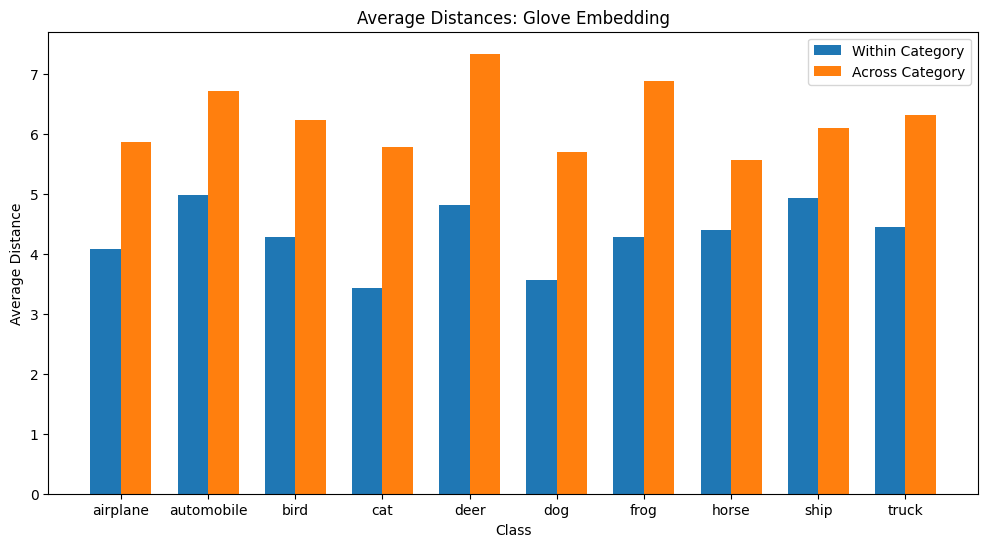

In [181]:
plot_distances(distances["Glove"]["Within"],distances["Glove"]["Across"],classes, "Glove")

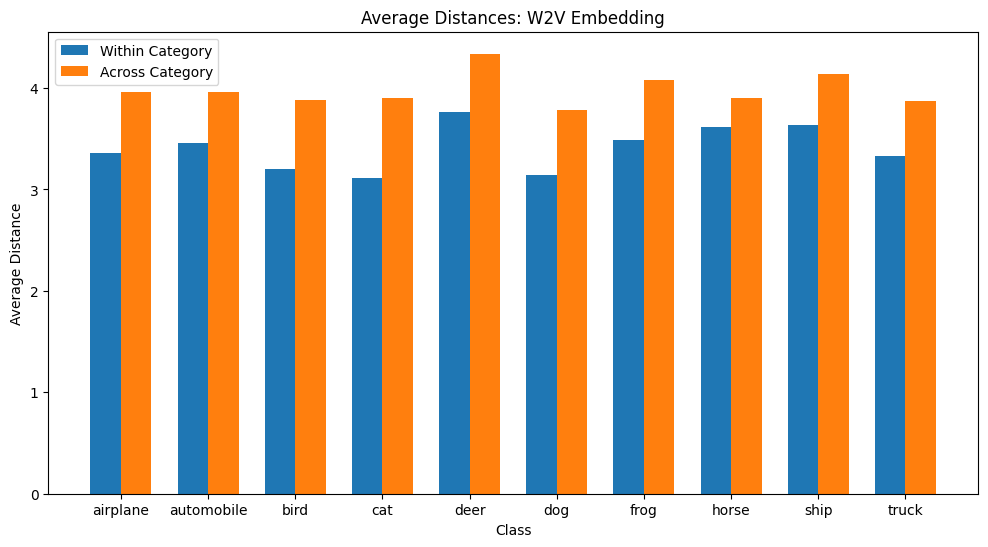

In [182]:
plot_distances(distances["W2V"]["Within"],distances["W2V"]["Across"],classes, "W2V")

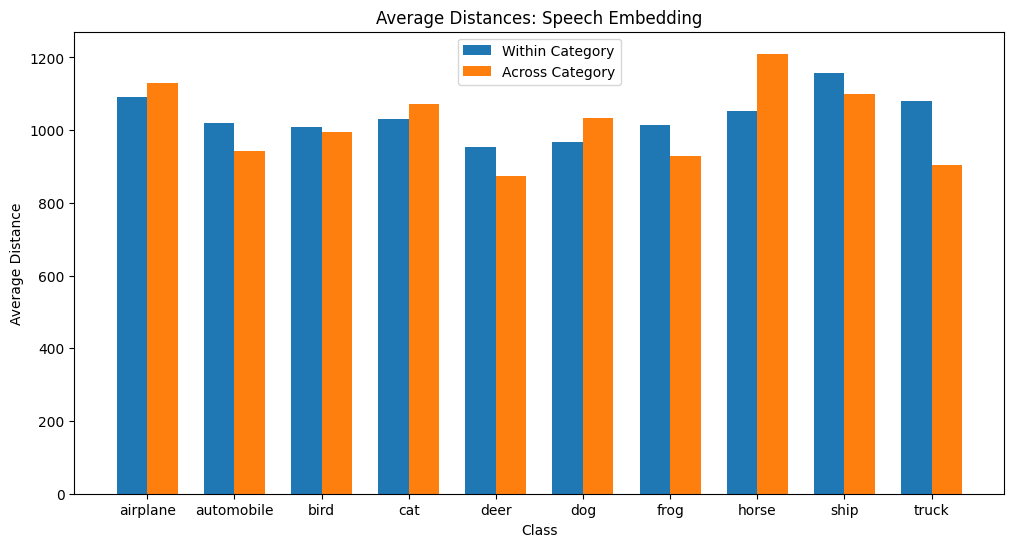

In [199]:
plot_distances(distances["Speech"]["Within"],distances["Speech"]["Across"],classes, "Speech")

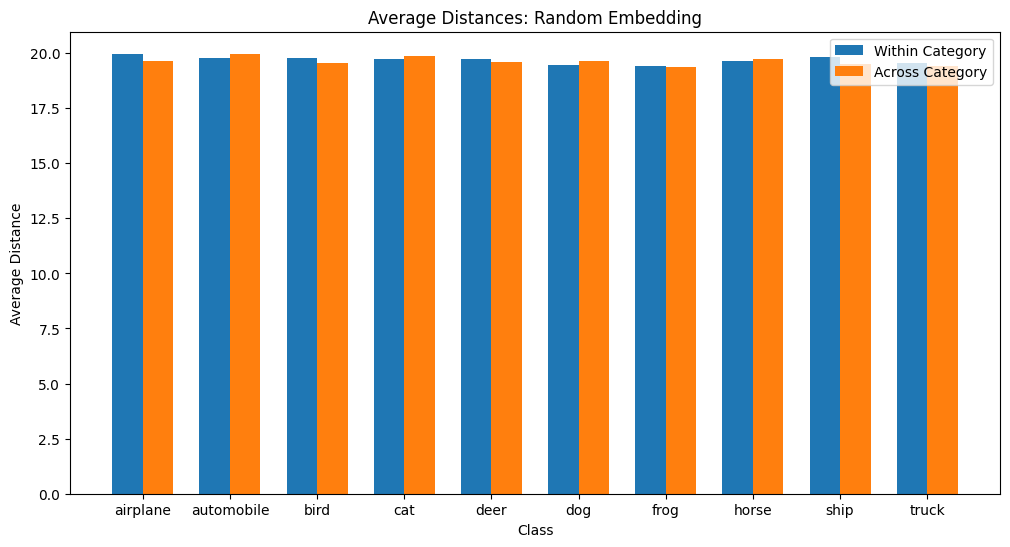

In [200]:
plot_distances(distances["Random"]["Within"],distances["Random"]["Across"],classes, "Random")